In [1]:
### Import Required Modules ###
import numpy as np                 #numpy for math
import pandas as pd                #pandas because they're cute
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles

### CREATE FUNCTIONS TO BE CALLED LATER ###

In [2]:
### Create function for Cressman Analysis ###
def cressman(dik, R):
    if dik <= R:
        w = (R**2 - dik**2) / (R**2 + dik**2)
    
    elif dik > R:
        w = 0
        
    else:
        print("Das hat nicht so ganz geklappt wie geplant")
        
    return w

In [3]:
### Create function for bilinear interpolation ###

def bilinear(x, y, ROI):
    rel_ind_x = x - np.floor(x)
    rel_ind_y = y - np.floor(y)
    
    z1 = f_A[int(np.floor(y)),int(np.floor(x)),ROI]
    z2 = f_A[int(np.ceil(y)),int(np.floor(x)),ROI]
    z3 = f_A[int(np.ceil(y)),int(np.ceil(x)),ROI]
    z4 = f_A[int(np.floor(y)),int(np.ceil(x)),ROI]
    
    P = (((rel_ind_x-1)*(rel_ind_y-1)*z1)-((rel_ind_x-0)*(rel_ind_y-1)*z2)+((rel_ind_x-0)*(rel_ind_y-0)*z3)-((rel_ind_x-1)*(rel_ind_y-0)*z4))
    
    return P

### DEFINE VARIABLES & SET UP ANALYSIS GRID ###

In [4]:
### define variables ###
xo = 18.9
yo = -6.3
delta_x = 1.27
delta_y = 1.27
phi_o = 60
lambda_o = -115
rho = 637100000. #convert from km to cm
map_scale = 1/15000000

### Read in observations ###
file = open("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\02-Successive_Corrections\\RAOBs_201903131200.txt", "r")
data= pd.read_csv(file, sep=",")
data[data.columns[1:5]]=data[data.columns[1:5]].astype(float) ## make text to numbers

fo = data['Height'].values #500-mb height values for obs
fo = np.array(fo) #do this due to those black & white fluffballs aka pandas


In [5]:
### convert obs lat/long to x,y ###

## convert obs from lat,lon to x,y
sigma = ((1.0+(np.sin(phi_o * np.pi / 180.))) / (1.0+(np.sin(data['Lat'] * np.pi / 180.))))
x_ob = sigma * rho * np.cos(data['Lat'] * np.pi / 180.) * np.cos((data['Lon']-lambda_o) * np.pi / 180.) * map_scale
y_ob = sigma * rho * np.cos(data['Lat'] * np.pi / 180.) * np.sin((data['Lon']-lambda_o) * np.pi / 180.) * map_scale

# make our obs x & y into an array for easier math-ing
x_ob = np.array(x_ob)
y_ob = np.array(y_ob)

## convert obs x,y back to lat,lon to plot
data_lon = np.arctan(y_ob/x_ob)*(180/np.pi)+lambda_o
data_lat=(180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x_ob/map_scale)**2+(y_ob/map_scale)**2)/(rho*(1+np.sin(phi_o*np.pi/180.))))))

In [6]:
### Set up analysis map with a 22x28 rectangular grid of points ###

## make a grid
xg = xo+np.arange(22)*delta_x
yg = yo+np.arange(28)*delta_y
x_grid, y_grid = np.meshgrid(xg,yg)

## convert grid from x,y to lat,lon for plotting purposes
grid_lon = np.arctan(y_grid/x_grid)*(180/np.pi)+lambda_o
grid_lat=(180/np.pi)*((np.pi/2)-(2*np.arctan(np.sqrt((x_grid/map_scale)**2+(y_grid/map_scale)**2)/(rho*(1+np.sin(phi_o*np.pi/180.))))))


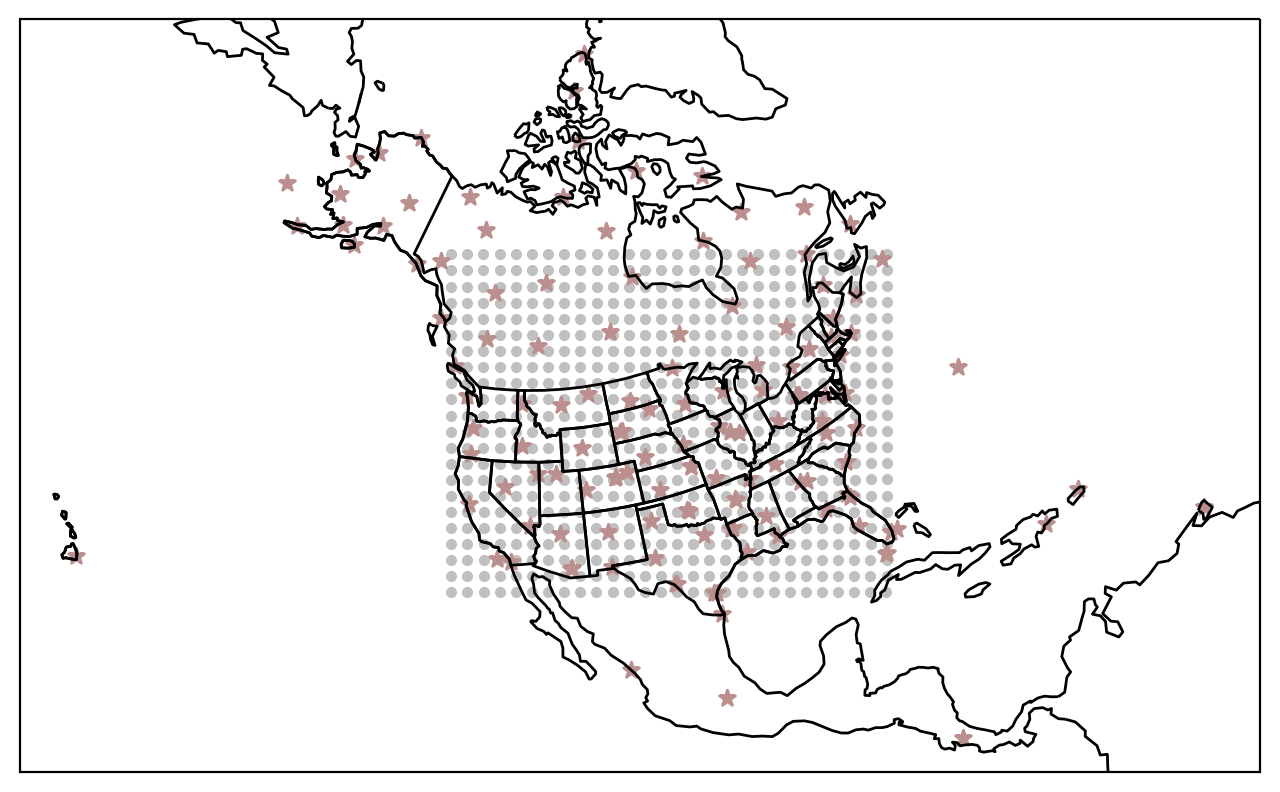

In [7]:
## plot obs and grid locations for verification ##

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
ax1.scatter(grid_lon.ravel(), grid_lat.ravel(), c='silver', marker='.', transform = ccrs.PlateCarree())
ax1.scatter(data_lon, data_lat, c='rosybrown', marker='*', transform = ccrs.PlateCarree())

#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\02-Successive_Corrections\\Obs_and_Grid_Locations.png")

plt.show()

### PERFORM 500mb GEOPOTENTIAL HEIGHT ANALYSES USING A CRESSMAN WEIGHTING FUNCTION ###

In [8]:
### SET UP RADII OF INFLUENCES ###

## calculate d_min since using radii of influence of 4, 2.5, & 1.5 *dmin
#d_min = closest ob to your ob on avg..... one number for all! (= 2.5548)

dist = np.zeros(len(x_ob))
for ü in range(len(x_ob)):
    d = (((x_ob[ü]-x_ob)**2)+((y_ob[ü]-y_ob)**2))**(1/2) #get the distance
    d = np.delete(d, ü) # delete the ü've value as this value would be 0 (distance from itself)
    dist[ü]=np.min(d) # get the minimum distance for each ob & store in an array

#now get the avg minimum distance
dmin = np.mean(dist)

## define the ROIs
R1 = 4 * dmin     # first pass' RoI
R2 = 2.5 * dmin   # second pass' RoI
R3 = 1.5 * dmin   # third pass' RoI

# define radius of influence matrix
ROI_arr = np.array([R1,R2,R3])

In [9]:
### FIRST ANALYSIS; NO BACKGROUND ###
## creating analysis values at grid points for proxy background values at grid points... 
# ...in order to then create 'background values' at obs locations in subsequent passes

## fa = sum(weights * fo) / sum(weights)

## empty matrix to be filled later with the analysis values
y_n=22
x_n=28
f_A = np.zeros((x_n, y_n, len(ROI_arr))) ##for our anaysis values

###############################################################################################################

# first pass (no background): fa = sum(weights * fo) / sum(weights) --> (f_A (r_i))
for m in range(len(x_grid)):
    for n in range(len(x_grid[0])):
        rel_x = x_grid[m,n] - x_ob ## subtract your obs from your analysis to get...
        rel_y = y_grid[m,n] - y_ob ## ...relative distance for our map
        radius = (rel_x**2 + rel_y**2)**(1/2) ## radius of influence for ith analysis point
        index_roi = np.where(radius <= ROI_arr[0])[0] ## only these obs will affect analysis value
        
        # calculate weights for each observation point using Cressman weight function
        weights = np.zeros(len(x_ob)) ## create empty matrix for weights
        for ä in index_roi:
            w = cressman(radius[ä], ROI_arr[0]) # call the Cressman function created previously
            weights[ä] = w # store the calculated values
        
        # these are the analysis values at the grid points (f_A (r_i))
        f_A[m,n,0] = np.sum(weights * fo) / np.sum(weights) #first pass                

In [10]:
### SECOND ANALYSIS; PROXY BACKGROUND ###
## use previous analysis values to create background values at obs locations & better the analysis @ grid points
## fa = fa(prev. run) + sum(weights * (fo-fb)) / sum(weights)

## get background values at obs locations from prev. analysis run --> (f_A (r_k))
#redefine index values for our obs to our grid
ind_x = (x_ob - xo)/delta_x
ind_y = (y_ob - yo)/delta_y

###############################################################################################################

fb = np.zeros((len(x_ob), len(ROI_arr)))
for ß in range(len(ind_x)):
    # if the obs location is in our grid, do bilinear interpolation
    if (ind_x[ß] >= 0 and ind_x[ß] < 21) and (ind_y[ß] >= 0 and ind_y[ß] < 27):
        P = bilinear(ind_x[ß], ind_y[ß], 0)
        
    # if the obs location is outside of our grid, do a 'reverse Cressman'
    else:
        rel_xa = x_ob[ß] - x_grid ## subtract your grid from your obs to get...
        rel_ya = y_ob[ß] - y_grid ## ...relative distance for our map
        radius_a = (rel_xa**2 + rel_ya**2)**(1/2) ## radius of influence for ith obs point
        index_roi_a = np.where(radius_a <= ROI_arr[0]) ## only these analyses will affect obs value
        
        ## do a weight function again, but now for giving weights to analyses to get that 'background value'
        weights_a = np.zeros(x_grid.shape)
        for µ in index_roi_a[0]:
            for s in index_roi_a[1]:
                w_a = cressman(radius_a[µ,s], ROI_arr[0]) 
                weights_a[µ,s] = w_a
        P = np.sum(weights_a * f_A[:,:,0]) / np.sum(weights_a)
    
    ## these are the analysis values at the obs locations (f_A (r_k))
    fb[ß,0] = P

###############################################################################################################

## get new analysis values at grid points --> (f_A² (r_i))
for m in range(len(x_grid)):
    for n in range(len(x_grid[0])):
        rel_x = x_grid[m,n] - x_ob # subtract your obs from your analysis to get...
        rel_y = y_grid[m,n] - y_ob # ...relative distance for our map
        radius = (rel_x**2 + rel_y**2)**(1/2) # radius of influence for ith analysis point
        index_roi = np.where(radius <= ROI_arr[1])[0] # only these obs will affect analysis value
        
        # get weights for each ob to influence grid points
        weights = np.zeros(len(x_ob))    
        for ä in index_roi:
            w = cressman(radius[ä], ROI_arr[1]) 
            weights[ä] = w
        
        # these are the analysis values at the grid points (f_A² (r_i))
        f_A[m,n,1] = f_A[m,n,0] + (np.nansum(weights * (fo-fb[:,0])) / np.nansum(weights))

C:\Users\julia\AppData\Local\Temp\ipykernel_16700\2283338650.py:31: RuntimeWarning: invalid value encountered in double_scalars
  P = np.sum(weights_a * f_A[:,:,0]) / np.sum(weights_a)


In [11]:
### THIRD ANALYSIS; PROXY BACKGROUND ###
## use previous analysis values to create better background values at obs locations & analysis @ grid points
## fa = fa(prev. run) + sum(weights * (fo-fb)) / sum(weights)

## get background values at obs locations from prev. analysis run --> (f_A² (r_k))
for ß in range(len(ind_x)):
    # if the obs location is in our grid, do bilinear interpolation
    if (ind_x[ß] >= 0 and ind_x[ß] < 21) and (ind_y[ß] >= 0 and ind_y[ß] < 27):
        P = bilinear(ind_x[ß], ind_y[ß], 1)
    
    # if the obs location is outside of our grid, do a 'reverse Cressman'
    else:
        rel_xa = x_ob[ß] - x_grid ## subtract your grid from your obs to get...
        rel_ya = y_ob[ß] - y_grid ## ...relative distance for our map
        radius_a = (rel_xa**2 + rel_ya**2)**(1/2) ## radius of influence for ith obs point
        index_roi_a = np.where(radius_a <= ROI_arr[1]) ## only these analyses will affect obs value
        
        ## do a weight function again, but now for giving weights to analyses to get that 'background value'
        weights_a = np.zeros(x_grid.shape)
        for µ in index_roi_a[0]:
            for s in index_roi_a[1]:
                w_a = cressman(radius_a[µ,s], ROI_arr[1]) 
                weights_a[µ,s] = w_a
        P = np.sum(weights_a * f_A[:,:,1]) / np.sum(weights_a)
    
    # these are the analysis values at the obs locations (f_A² (r_k))
    fb[ß,1] = P

###############################################################################################################

## get new analysis values at grid points --> (f_A³ (r_i))
for m in range(len(x_grid)):
    for n in range(len(x_grid[0])):
        rel_x = x_grid[m,n] - x_ob # subtract your obs from your analysis to get...
        rel_y = y_grid[m,n] - y_ob # ...relative distance for our map
        radius = (rel_x**2 + rel_y**2)**(1/2) # radius of influence for ith analysis point
        index_roi = np.where(radius <= ROI_arr[2])[0] # only these obs will affect analysis value
        
        # get weights for each ob to influence grid points
        weights = np.zeros(len(x_ob))    
        for ä in index_roi:
            w = cressman(radius[ä], ROI_arr[2]) 
            weights[ä] = w
        
        # these are the analysis values at the grid points (f_A³ (r_i))
        f_A[m,n,2] = f_A[m,n,1] + (np.nansum(weights * (fo-fb[:,1])) / np.nansum(weights))

C:\Users\julia\AppData\Local\Temp\ipykernel_16700\982180635.py:24: RuntimeWarning: invalid value encountered in double_scalars
  P = np.sum(weights_a * f_A[:,:,1]) / np.sum(weights_a)
C:\Users\julia\AppData\Local\Temp\ipykernel_16700\982180635.py:46: RuntimeWarning: invalid value encountered in double_scalars
  f_A[m,n,2] = f_A[m,n,1] + (np.nansum(weights * (fo-fb[:,1])) / np.nansum(weights))


### ANALYSES ARE COMPLETE SO NOW NEED TO SEE HOW THEY ALL COMPARE ###

In [12]:
### ANALYSIS DIFFERENCES ###

ad = np.zeros((x_n, y_n, len(ROI_arr)))

## second pass - first pass
ad[:,:,0] = f_A[:,:,1] - f_A[:,:,0]

## third pass - first pass
ad[:,:,1] = f_A[:,:,2] - f_A[:,:,0]

## third pass - second pass
ad[:,:,2] = f_A[:,:,2] - f_A[:,:,1]

In [13]:
### ROOT MEAN SQUARE DIFFERENCES ###
# calculate Root Mean Square Differences between analyses & obs for each pass
# rms = sqrt (sum(fo-fb)²/K)

rms = np.zeros((len(ROI_arr)))

## first pass
fp_dif = (fo-fb[:,0])**2 #fb is our f_A (r_k) values
fp_dif = fp_dif[~np.isnan(fp_dif)] #delete the nan values
rms[0]=np.sqrt((np.sum(fp_dif))/len(fp_dif))


## second pass
sp_dif = (fo-fb[:,1])**2 #fb is our f_A² (r_k) values
sp_dif = sp_dif[~np.isnan(sp_dif)]  #delete the nan values
rms[1]=np.sqrt((np.sum(sp_dif))/len(sp_dif))


## third pass
# need to calculate (f_A³ (r_k)) for our fb values
for ß in range(len(ind_x)):
    # if the obs location is in our grid, do bilinear interpolation
    if (ind_x[ß] >= 0 and ind_x[ß] < 21) and (ind_y[ß] >= 0 and ind_y[ß] < 27):
        P = bilinear(ind_x[ß], ind_y[ß], 2)
    
    # if the obs location is outside of our grid, do a 'reverse Cressman'
    else:
        rel_xa = x_ob[ß] - x_grid ## subtract your grid from your obs to get...
        rel_ya = y_ob[ß] - y_grid ## ...relative distance for our map
        radius_a = (rel_xa**2 + rel_ya**2)**(1/2) ## radius of influence for ith obs point
        index_roi_a = np.where(radius_a <= ROI_arr[2]) ## only these analyses will affect obs value
        
        ## do a weight function again, but now for giving weights to analyses to get that 'background value'
        weights_a = np.zeros(x_grid.shape)
        for µ in index_roi_a[0]:
            for s in index_roi_a[1]:
                w_a = cressman(radius_a[µ,s], ROI_arr[2]) 
                weights_a[µ,s] = w_a
        P = np.sum(weights_a * f_A[:,:,2]) / np.sum(weights_a)
    
    #these are the analysis values at the obs locations (f_A³ (r_k))
    fb[ß,2] = P
###############################################################################################################
tp_dif = (fo-fb[:,2])**2 #fb is our (f_A³ (r_k)) values (from loop above)
tp_dif = tp_dif[~np.isnan(tp_dif)]  #delete the nan values
rms[2]=np.sqrt((np.nansum(tp_dif))/len(tp_dif))

### PLOT ANALYSES & ANALYSIS DIFFERENCES ON A MAP ###

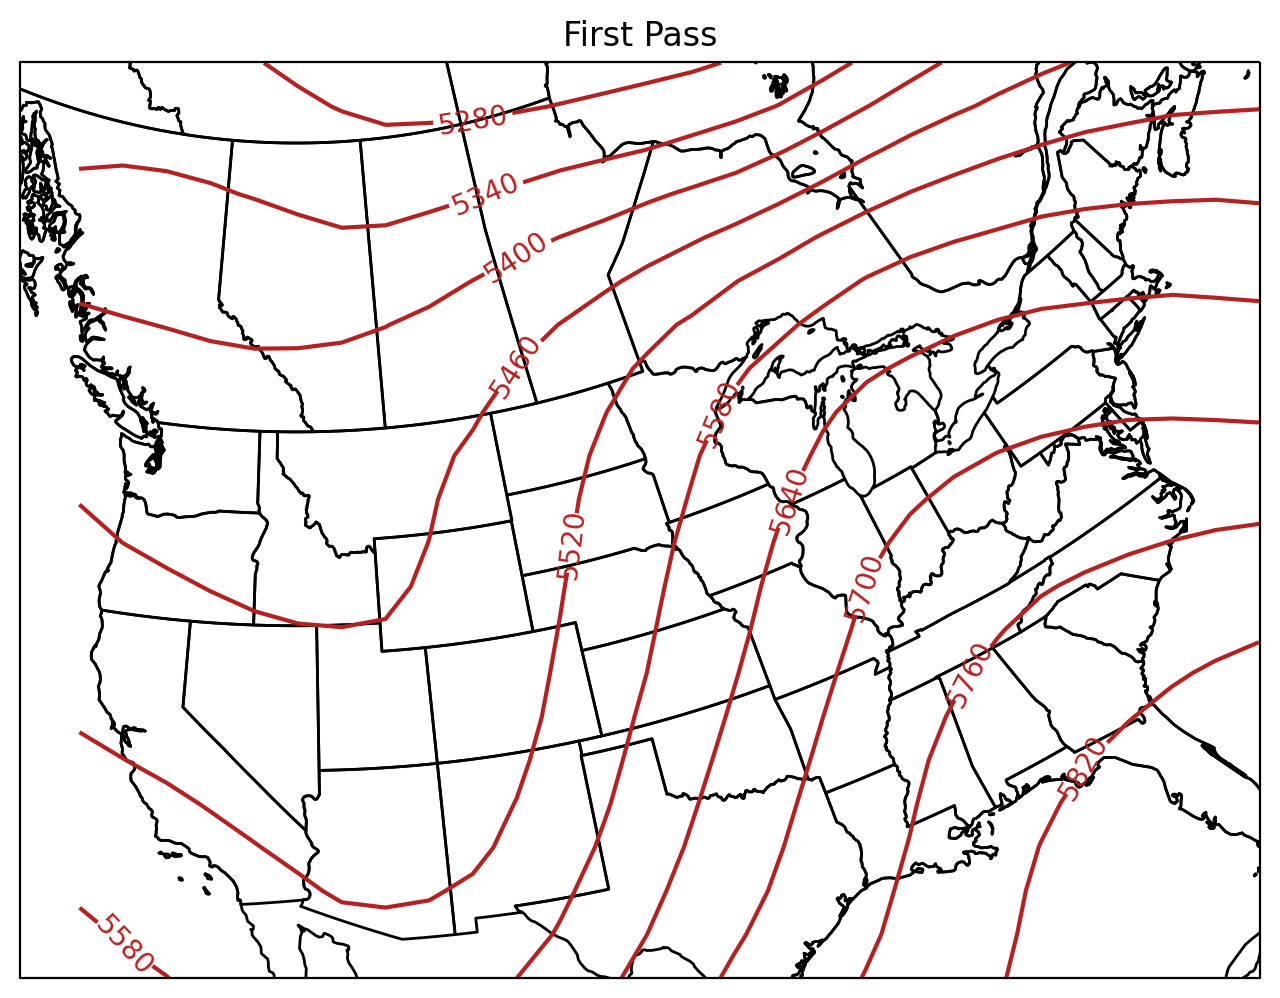

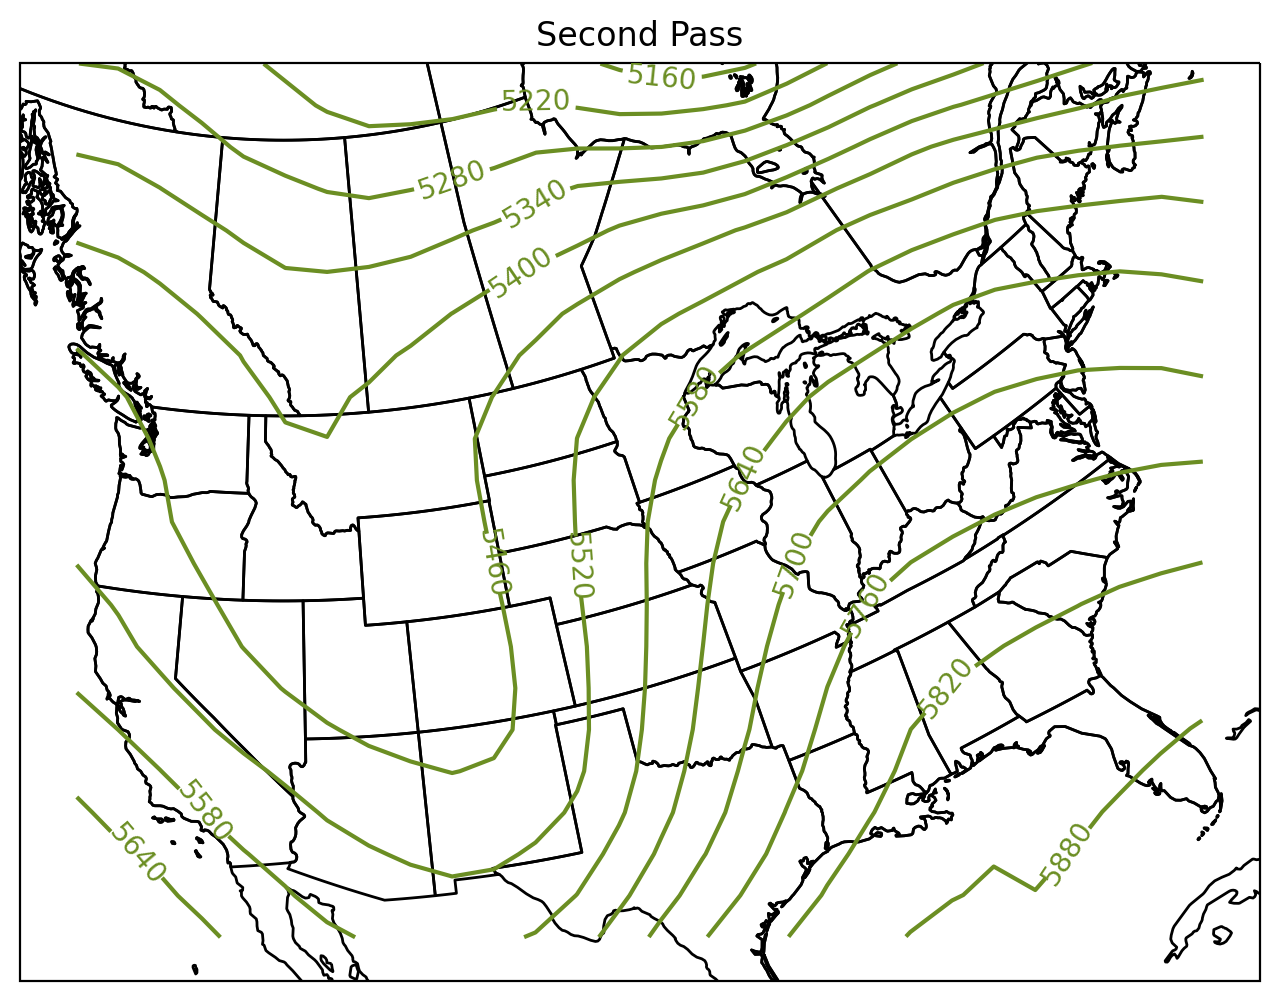

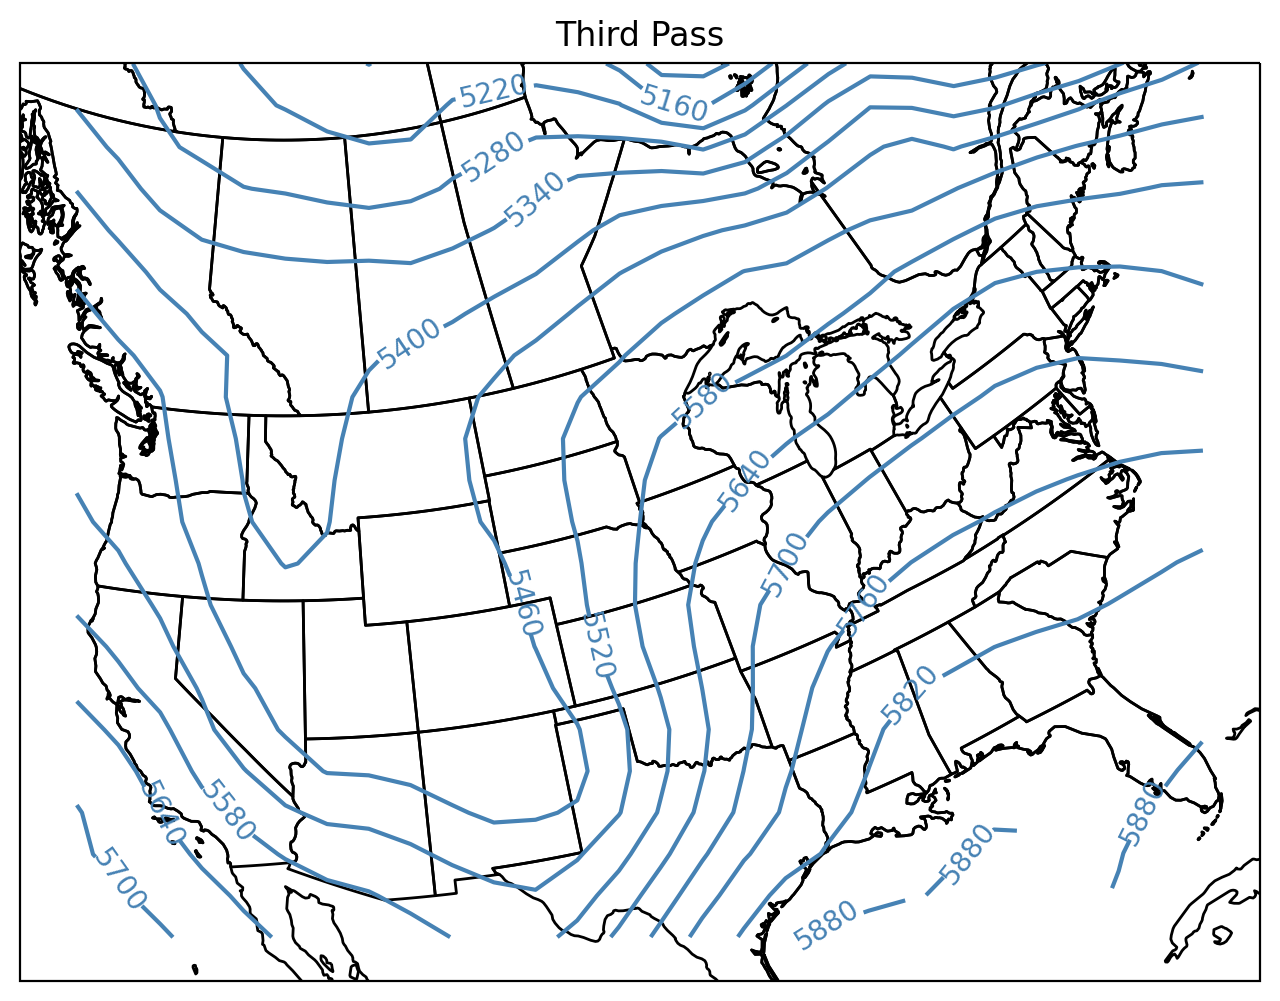

In [14]:
### PLOT 500mb ANALYSES ON A MAP ###

## first pass (f_A (r_i))
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
## plot grid lat & lons because we want analysis locations NOT obs locations
cs1 = ax1.contour(grid_lon,grid_lat,f_A[:,:,0],colors='firebrick',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("First Pass")
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\02-Successive_Corrections\\First_Pass.png")
plt.show()


## second pass (f_A² (r_i))
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
## plot grid lat & lons because we want analysis locations NOT obs locations
cs1 = ax1.contour(grid_lon,grid_lat,f_A[:,:,1],colors='olivedrab',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("Second Pass")
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\02-Successive_Corrections\\Second_Pass.png")
plt.show()


## third pass (f_A³ (r_i))
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
## plot grid lat & lons because we want analysis locations NOT obs locations
cs1 = ax1.contour(grid_lon,grid_lat,f_A[:,:,2],colors='steelblue',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("Third Pass")
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\02-Successive_Corrections\\Third_Pass.png")
plt.show()

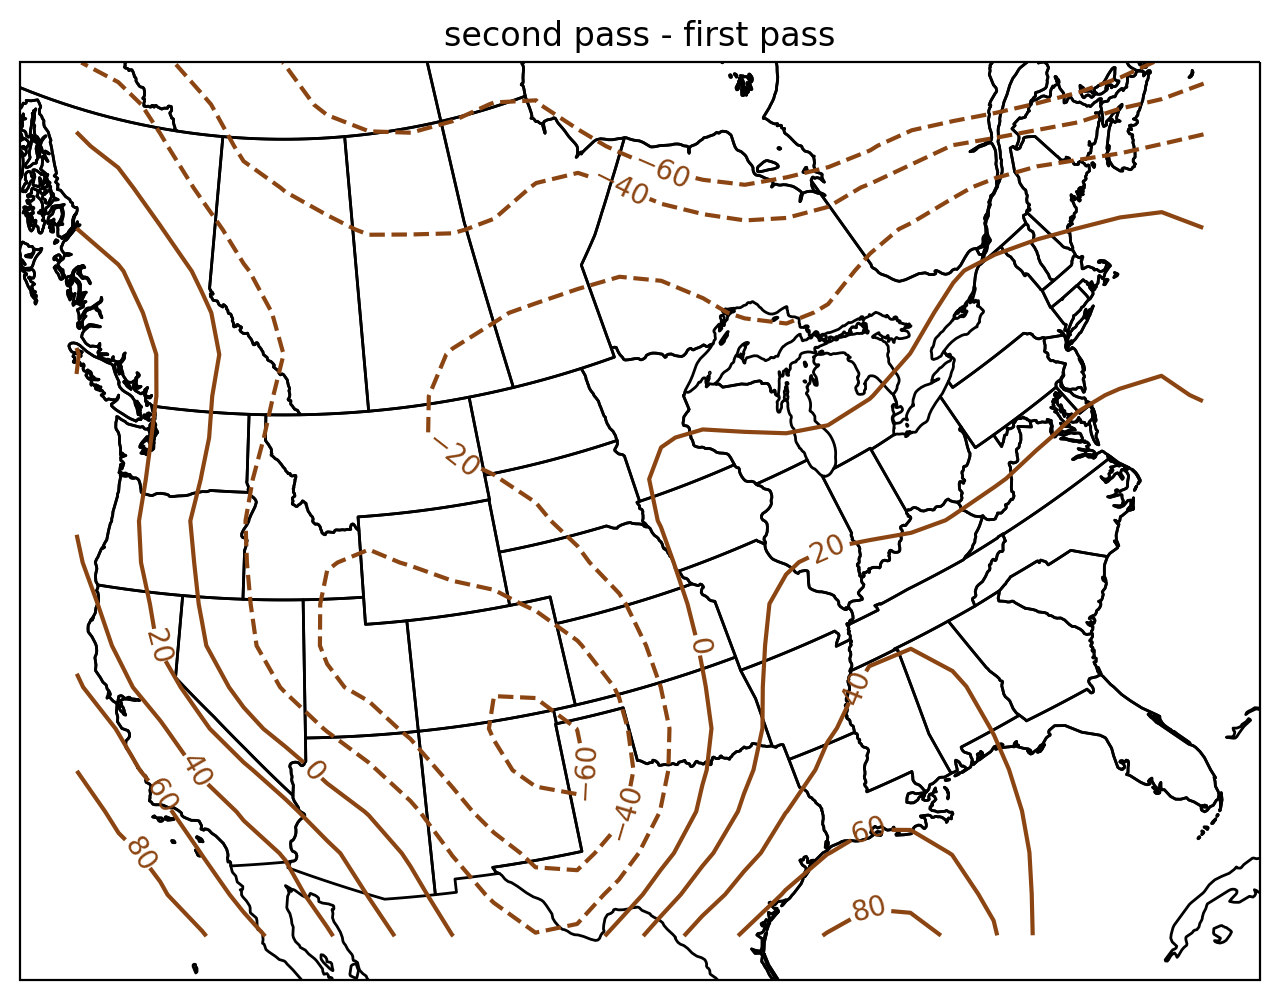

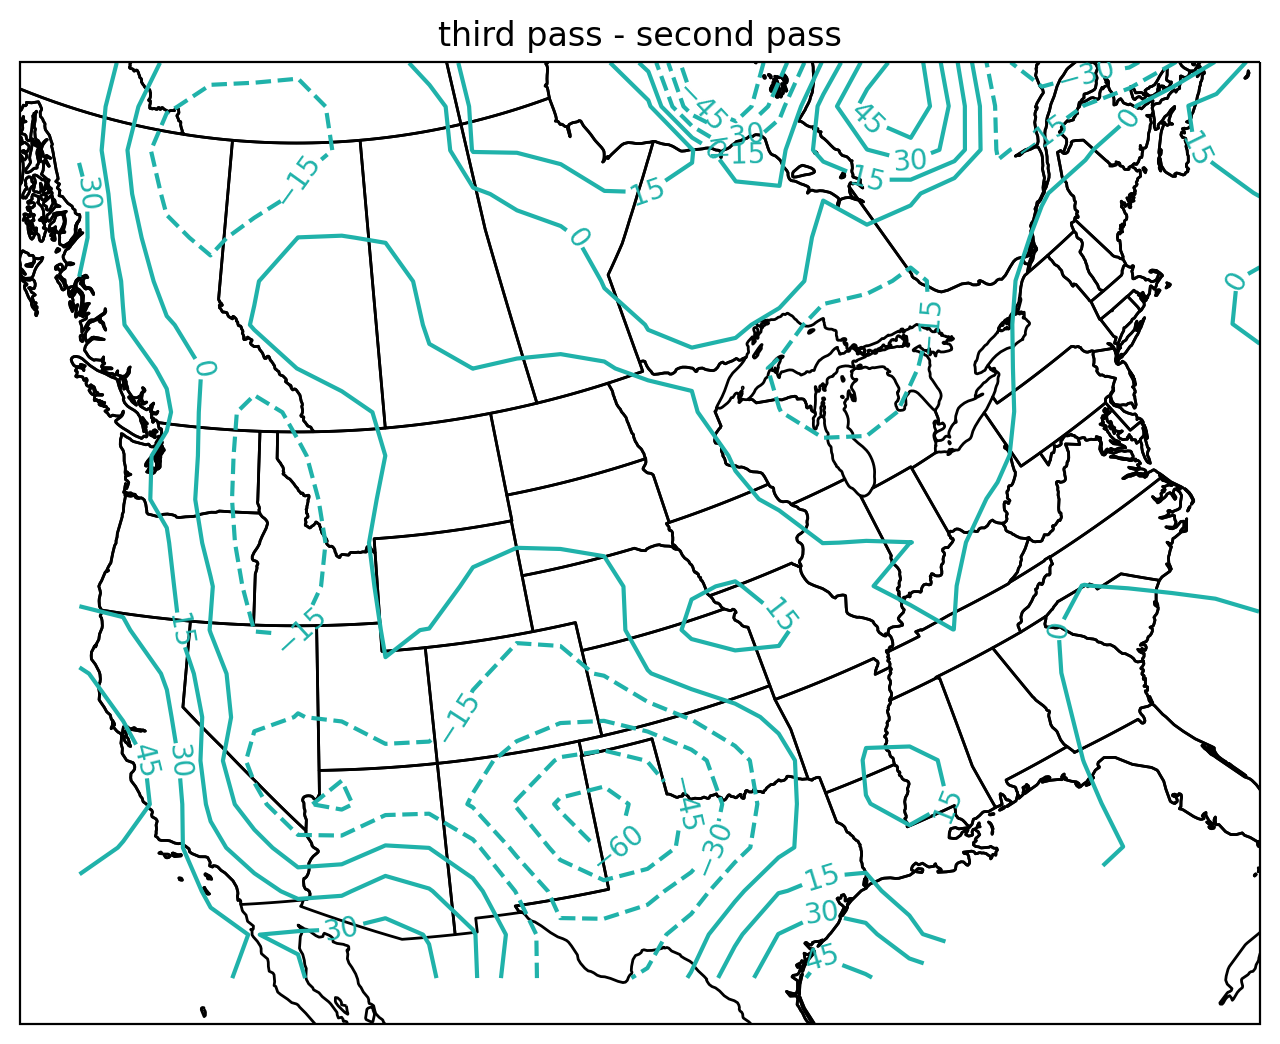

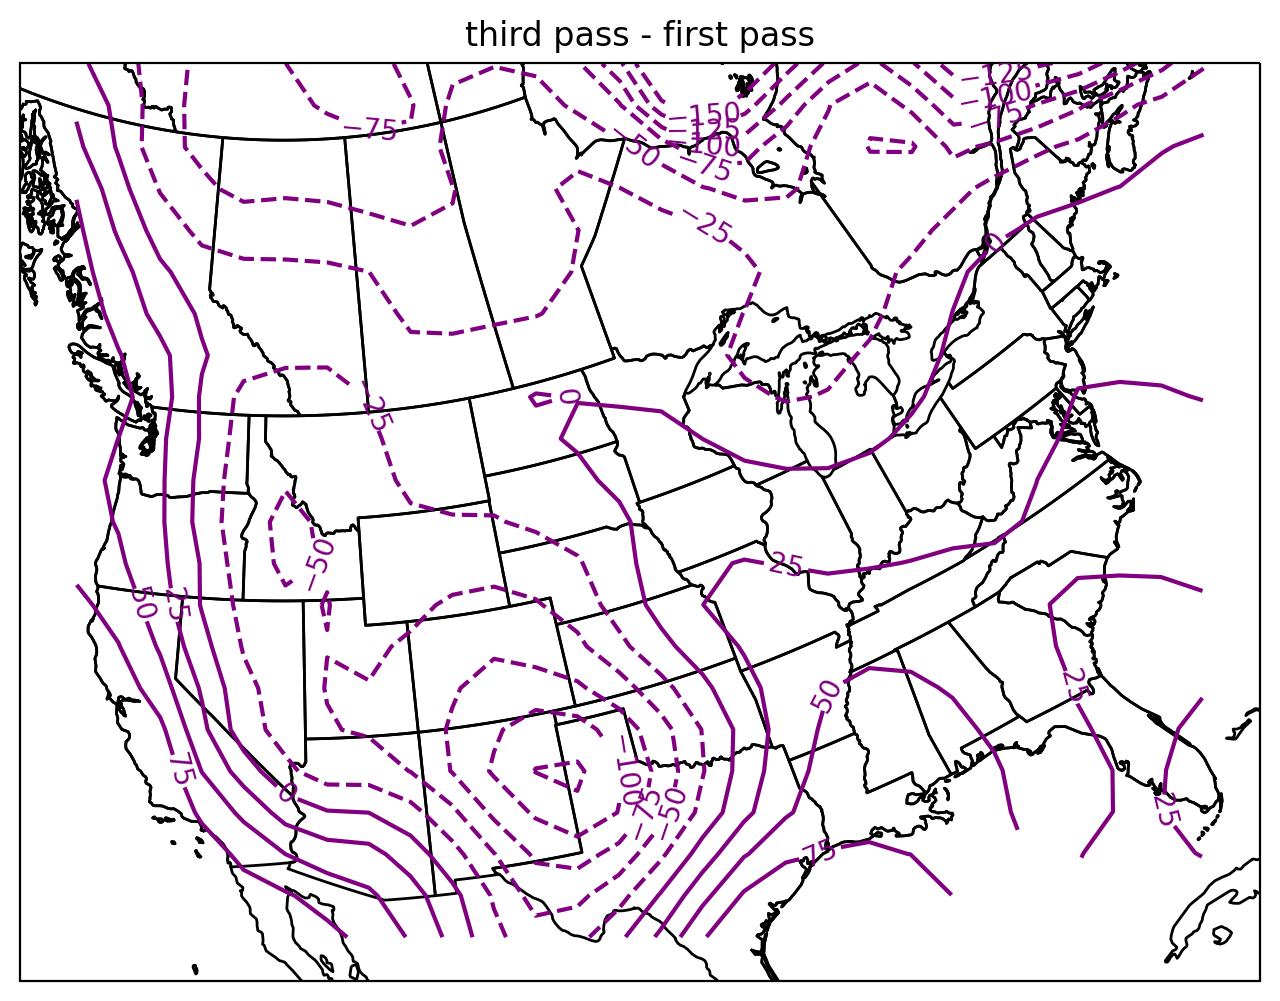

In [15]:
### PLOT THE ANALYSIS DIFFERENCES ###

## second pass - first pass
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
## plot grid lat & lons because we want analysis locations NOT obs locations
cs1 = ax1.contour(grid_lon,grid_lat,ad[:,:,0],colors='saddlebrown',levels=np.arange(-60,90,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-60,90,20))
plt.title("second pass - first pass")
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\02-Successive_Corrections\\Second-First.png")
plt.show()


## third pass - second pass
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
## plot grid lat & lons because we want analysis locations NOT obs locations
cs1 = ax1.contour(grid_lon,grid_lat,ad[:,:,2],colors='lightseagreen',levels=np.arange(-60,60,15),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-60,60,15))
plt.title("third pass - second pass")
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\02-Successive_Corrections\\Third-Second.png")
plt.show()


## third pass - first pass
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)
## plot grid lat & lons because we want analysis locations NOT obs locations
cs1 = ax1.contour(grid_lon,grid_lat,ad[:,:,1],colors='purple',levels=np.arange(-150,100,25),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-150,100,25))
plt.title("third pass - first pass")
#plt.savefig("C:\\Users\\julia\\Documents\\GitHub\\ATSC528_2022\\02-Successive_Corrections\\Third-First.png")
plt.show()


### STORE EVERYTHING IN TEXT FILES ###

In [16]:
### Store the analyses in text files ###
with open('analysis_values.txt', 'wb') as f:
    for line in f_A:
        np.savetxt(f, line)


### Store the 'background values' in text files ###
fb_file = open('background_values.txt', 'w+')
fb_string = str(fb)
fb_file.write(fb_string)
fb_file.close()
        
        
### Store the difference fields in text files ###
with open('difference_fields.txt', 'wb') as f:
    for line in ad:
        np.savetxt(f, line)
        
        
### Store RMS values in text file ###
rms_file = open('root_mean_square_differences.txt', 'w+')
rms_string = str(rms)
rms_file.write(rms_string)
rms_file.close()

### ~fin code ###